In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_1593/3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
test_df = pd.read_csv('SRER21_dataset_v1.csv', na_values='?').dropna()
train_df = pd.read_csv('SRER_2017_training_bi.csv', na_values='?').dropna()
train_df.head()
test_df.head()

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,2,2,2,20.4,2.38,1.000000,0.273945,0.273945,0.273945,0.323257,0.323257,0.323257,0.428208,0.428208,0.428208,0.311936,0.311936,0.311936,woody
1,3,3,3,8.2,1.32,1.000000,0.530157,0.530157,0.530157,0.460513,0.460513,0.460513,0.611745,0.611745,0.611745,0.416492,0.416492,0.416492,woody
2,4,4,4,55.8,24.43,0.920000,0.477979,0.501013,0.616707,0.381095,0.384718,0.447304,0.576437,0.596638,0.673767,0.359786,0.364317,0.414173,woody
3,5,5,5,15.2,1.88,1.000000,0.342944,0.342944,0.342944,0.346714,0.346714,0.346714,0.468738,0.468738,0.468738,0.323907,0.323907,0.323907,woody
4,6,6,6,27.2,9.29,0.142857,0.044382,-0.008903,0.265536,0.181714,0.147391,0.315684,0.223522,0.178629,0.412030,0.177739,0.147325,0.299311,non-woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/bas

---Run time is 0.08817059300000007 seconds ---

Accuracy of each fold: 
 [0.716589861751152, 0.6820276497695853, 0.7223502304147466, 0.7096774193548387, 0.7001153402537486]
Avg accuracy: 0.7061521003088143
Std of accuracy : 
0.01415758272456331

[[ 257 1202]
 [  73 2807]]

              precision    recall  f1-score   support

   non-woody       0.78      0.18      0.29      1459
       woody       0.70      0.97      0.81      2880

    accuracy                           0.71      4339
   macro avg       0.74      0.58      0.55      4339
weighted avg       0.73      0.71      0.64      4339

0.17614804660726524
0.9746527777777778
0.7787878787878788
0.2873113471212968


In [7]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []
  
for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 0.29343399999999953 seconds ---

Accuracy of each fold: 
 [0.7419354838709677, 0.684331797235023, 0.7361751152073732, 0.7131336405529954, 0.7174163783160323]
Avg accuracy: 0.7185984830364783
Std of accuracy : 
0.020292960538940277

[[ 349 1110]
 [ 111 2769]]

              precision    recall  f1-score   support

   non-woody       0.76      0.24      0.36      1459
       woody       0.71      0.96      0.82      2880

    accuracy                           0.72      4339
   macro avg       0.74      0.60      0.59      4339
weighted avg       0.73      0.72      0.67      4339

0.23920493488690883
0.9614583333333333
0.758695652173913
0.36373110995310054


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/bas

In [8]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


---Run time is 0.46770047999999953 seconds ---

Accuracy of each fold: 
 [0.738479262672811, 0.7142857142857143, 0.7350230414746544, 0.7315668202764977, 0.7324106113033448]
Avg accuracy: 0.7303530900026045
Std of accuracy : 
0.008387016472212159

[[ 481  978]
 [ 192 2688]]

              precision    recall  f1-score   support

   non-woody       0.71      0.33      0.45      1459
       woody       0.73      0.93      0.82      2880

    accuracy                           0.73      4339
   macro avg       0.72      0.63      0.64      4339
weighted avg       0.73      0.73      0.70      4339

0.3296778615490062
0.9333333333333333
0.7147102526002972
0.45121951219512196


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [9]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.63018433 0.62327189 0.62442396 0.61866359 0.59976932]

Avg accuracy: 0.6192626196588693

K=2

Accuracy of each fold: 
 [0.64170507 0.61866359 0.62672811 0.60599078 0.61937716]

Avg accuracy: 0.6224929440466889

K=3

Accuracy of each fold: 
 [0.6578341  0.62442396 0.62903226 0.63709677 0.62745098]

Avg accuracy: 0.63516761543327

K=4

Accuracy of each fold: 
 [0.6624424  0.63479263 0.65092166 0.61866359 0.62745098]

Avg accuracy: 0.6388542513779705

K=5

Accuracy of each fold: 
 [0.65898618 0.62557604 0.64861751 0.6359447  0.64821223]

Avg accuracy: 0.6434673300060061

K=6

Accuracy of each fold: 
 [0.66820276 0.64170507 0.66013825 0.62327189 0.65513264]

Avg accuracy: 0.6496901227284082

K=7

Accuracy of each fold: 
 [0.67857143 0.64516129 0.64631336 0.64170507 0.65743945]

Avg accuracy: 0.6538381196881029

K=8

Accuracy of each fold: 
 [0.66935484 0.65207373 0.6624424  0.63364055 0.66320646]

Avg accuracy: 0.6561435959583075

K=9

Accuracy of each fold

In [10]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=8)

acc_score = []
Truth = []
Output = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 2.892164362999999 seconds ---

Accuracy of each fold: 
 [0.7569124423963134, 0.7523041474654378, 0.7914746543778802, 0.7730414746543779, 0.7993079584775087]
Avg accuracy: 0.7746081354743037
Std of accuracy : 
0.01848037108420237



/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/bas

[[ 689  770]
 [ 208 2672]]

              precision    recall  f1-score   support

   non-woody       0.77      0.47      0.58      1459
       woody       0.78      0.93      0.85      2880

    accuracy                           0.77      4339
   macro avg       0.77      0.70      0.72      4339
weighted avg       0.77      0.77      0.76      4339

0.4722412611377656
0.9277777777777778
0.7681159420289855
0.5848896434634974


In [11]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.706152,0.014158,0.176148,0.974653,0.778788,0.287311,0.088171
LDA,0.718598,0.020293,0.239205,0.961458,0.758696,0.363731,0.293434
QDA,0.730353,0.008387,0.329678,0.933333,0.714710,0.451220,0.467700
KNN-CV,0.774608,0.018480,0.472241,0.927778,0.768116,0.584890,2.892164


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.7061521003088143, 0.7185984830364783, 0.7303530900026045, 0.7746081354743037]
Sen[0.17614804660726524, 0.23920493488690883, 0.3296778615490062, 0.4722412611377656]
Spec[0.9746527777777778, 0.9614583333333333, 0.9333333333333333, 0.9277777777777778]
P[0.7787878787878788, 0.758695652173913, 0.7147102526002972, 0.7681159420289855]
F1[0.2873113471212968, 0.36373110995310054, 0.45121951219512196, 0.5848896434634974]


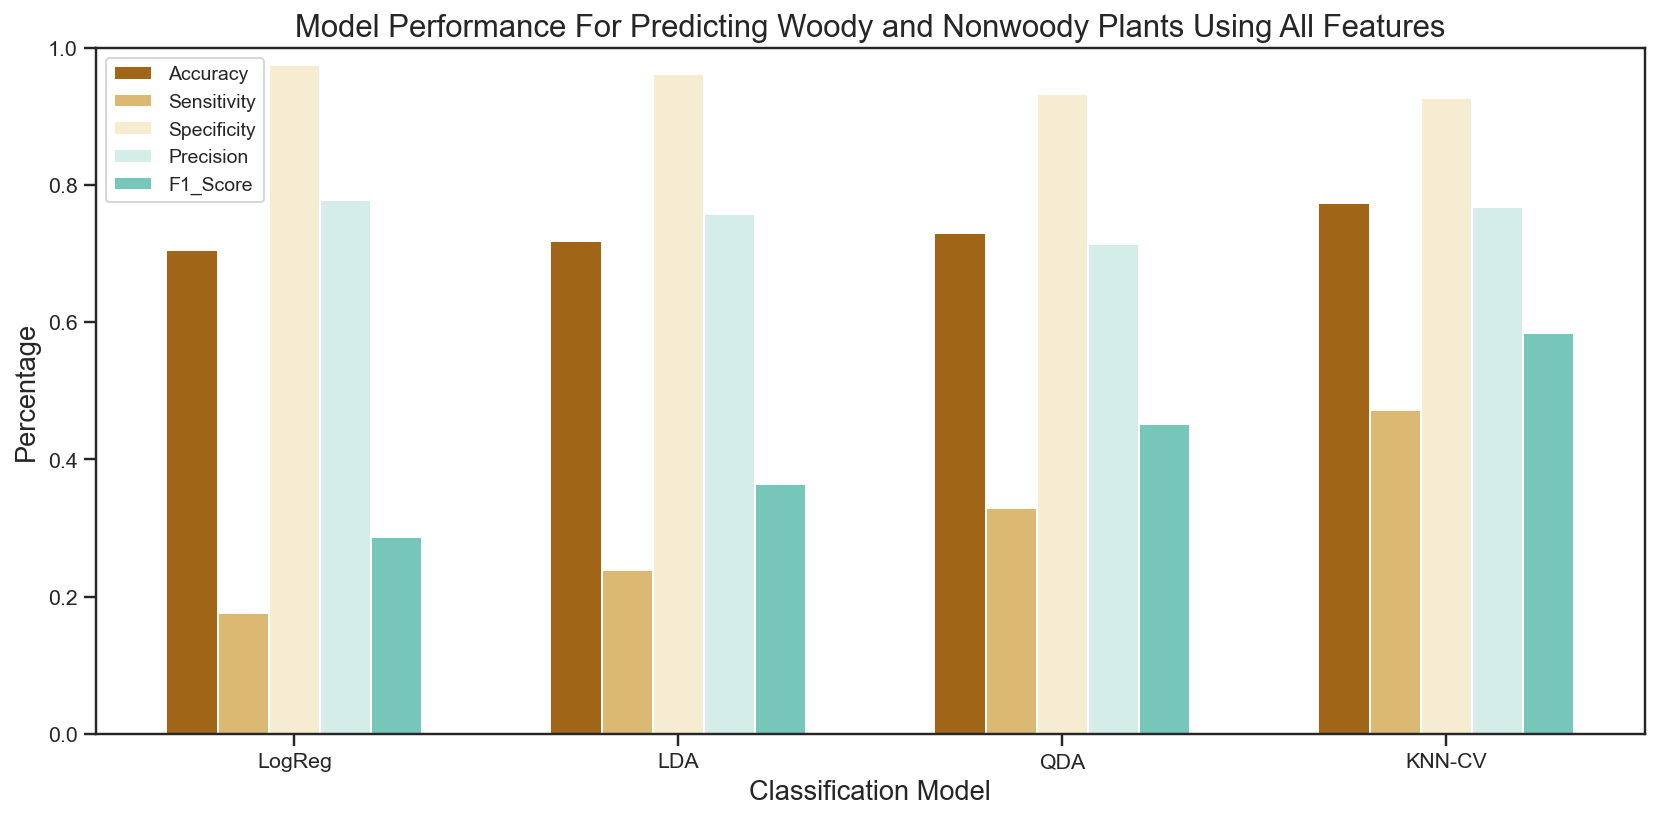

In [19]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

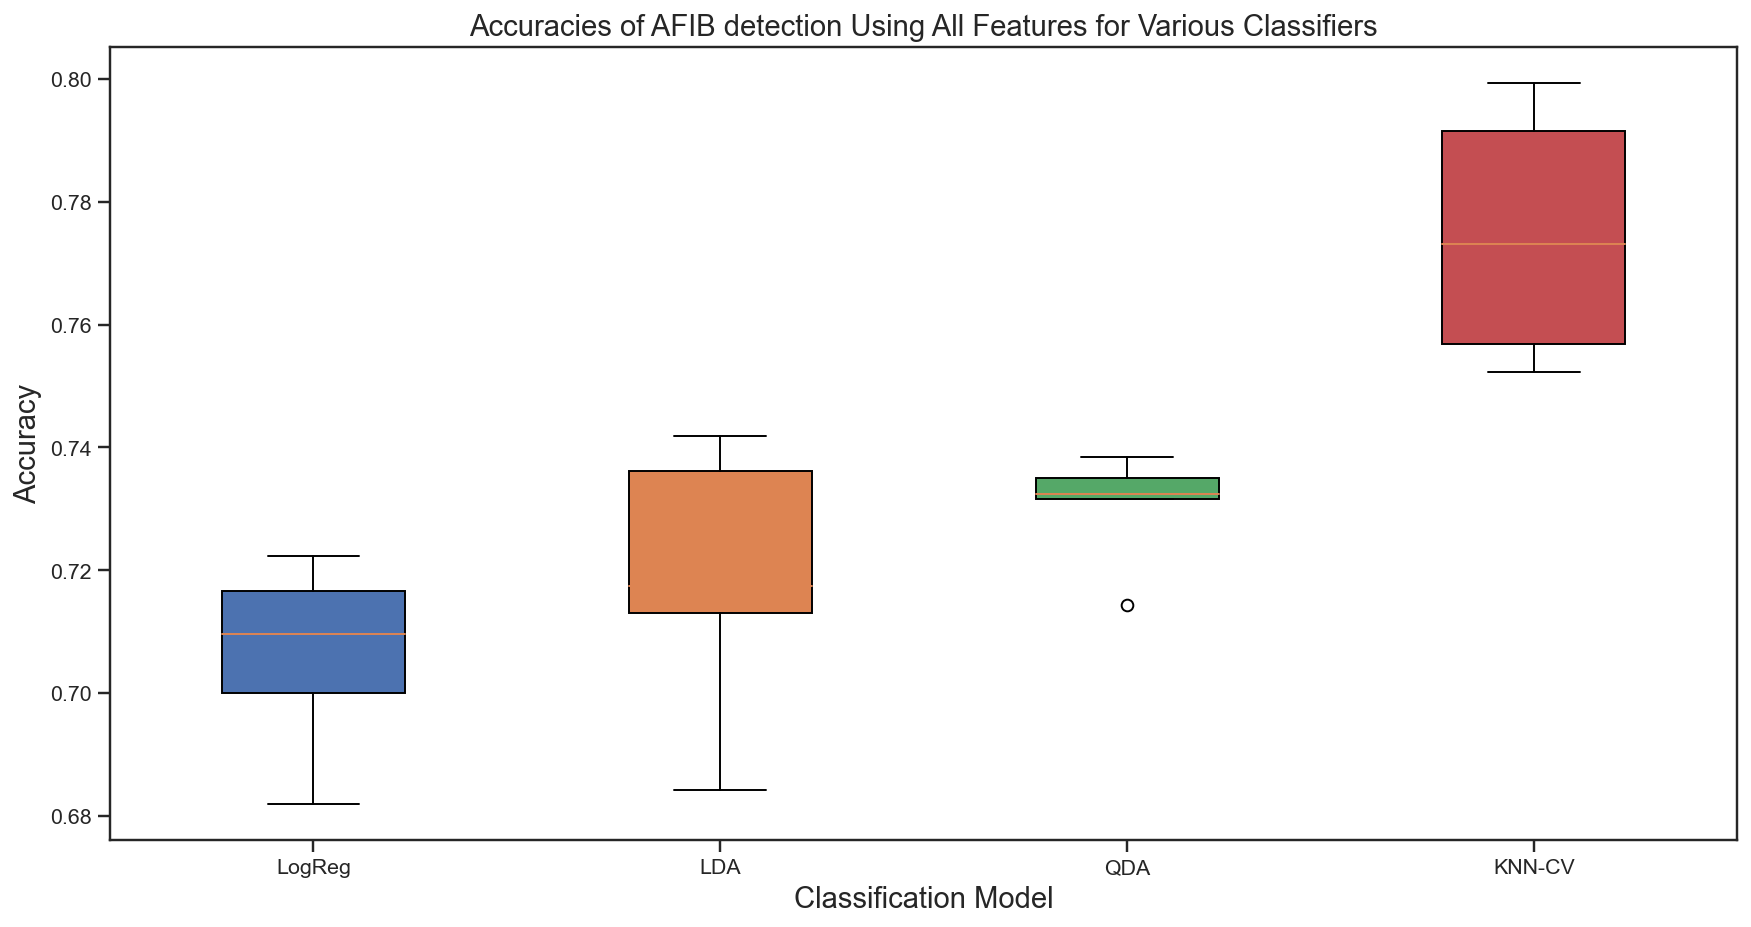

In [13]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()